# **Support vector machine sigmoid kernel (SVM with sigmoid)**

## **1. Import necessary libraries**

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from sklearn import utils
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings('ignore')

import sys
sys.executable

'/home/dagngyen5462/miniconda3/envs/min_ds-env/bin/python'

## **2. Insert and preprocess data**

### **2.1. Load data**
Load our data from path `../Data/processed_data.csv`.

In [3]:
# Load our data from path `../Data/processed_data.csv`
courses_df = pd.read_csv('../Data/processed_data.csv', sep=',',engine='python', encoding='utf-8')
courses_df.sample(5)

,name,general,specify,enrollment,language,rating,level,duration,instructor,instructor_rate,offered by
3833,Mountains 101,Physical Science and Engineering,Environmental Science and Sustainability,74401,English,4.9,Other,18,"Zac Robinson, David Hik",4.9,University of Alberta
1928,Estratégicos empresariales: Proyecto final,Business,Business Strategy,13926,Spanish,4.2,Other,10,Norman Wolf del Valle,4.7,Universidad Nacional Autónoma de México
1714,China’s Economic Transformation Part 1: Econom...,Social Sciences,Economics,11118,English,4.8,Beginner,12,Albert Park,4.8,The Hong Kong University of Science and Techno...
1668,"Drugs, drug use, drug policy and health",Health,Public Health,32523,English,4.8,Beginner,29,"Jennifer Hasselgard-Rowe, Michel Kazatchkine, ...",4.7,University of Geneva
3677,Medir y optimizar campañas de marketing en red...,Business,Marketing,4516,Spanish,4.9,Beginner,8,Anke Audenaert,4.9,Meta


### **2.2. Preprocess data**

- The `name` and `instructor` features needs to be removed because it is not useful in training the model.

In [4]:
data_ = courses_df.copy().drop(columns=['name', 'instructor'])
data_.sample(5)

,general,specify,enrollment,language,rating,level,duration,instructor_rate,offered by
155,Physical Science and Engineering,Mechanical Engineering,16357,English,4.6,Beginner,18,4.5,The State University of New York
4938,Social Sciences,Governance and Society,54017,English,4.5,Other,19,4.6,Rutgers the State University of New Jersey
1800,Health,Patient Care,54147,Spanish,4.8,Intermediate,8,4.8,Pontificia Universidad Católica de Chile
5457,Computer Science,Software Development,83185,English,4.6,Beginner,8,4.7,University of Virginia
996,Business,Business Essentials,11229,English,4.9,Beginner,14,4.9,Institute for the Future


- Explore missing values in variables:
    + View summary of dataset.

In [5]:
data_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5718 entries, 0 to 5717
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   general          5717 non-null   object 
 1   specify          5717 non-null   object 
 2   enrollment       5718 non-null   int64  
 3   language         5718 non-null   object 
 4   rating           5718 non-null   float64
 5   level            5718 non-null   object 
 6   duration         5718 non-null   int64  
 7   instructor_rate  5718 non-null   float64
 8   offered by       5703 non-null   object 
dtypes: float64(2), int64(2), object(5)
memory usage: 402.2+ KB


In [6]:
print('Number missing values in each column:\n',data_.isnull().sum())

Number missing values in each column:
 general             1
specify             1
enrollment          0
language            0
rating              0
level               0
duration            0
instructor_rate     0
offered by         15
dtype: int64


- Explore missing values in variables:
    + Drop rows with missing values: Because the number of missing values each variable is insignificant, we will remove rows containing missing data.

In [7]:
# Drop rows with missing values
data_.dropna(inplace=True)
print('Number missing values in each column:\n',data_.isnull().sum())

Number missing values in each column:
 general            0
specify            0
enrollment         0
language           0
rating             0
level              0
duration           0
instructor_rate    0
offered by         0
dtype: int64


## **3. Prepare for training model**

### **3.1. Define kind of features**

- Define selection and target features to prepare data for training model.

In [8]:
# Define selection and target features to prepare data for training model
target = ['rating']
specificities = list(set(data_.columns) - set(target))

- Define numerical and categorical features to transformer.

In [9]:
# Define numerical and categorical features
numeracy_ = list(set(specificities) - set(courses_df.select_dtypes(include=['object']).columns))
category_ = list(set(specificities) - set(courses_df.select_dtypes(exclude=['object']).columns))
print('Numerical features:', numeracy_)
print('Categorical features:', category_)

Numerical features: ['instructor_rate', 'enrollment', 'duration']
Categorical features: ['level', 'language', 'offered by', 'general', 'specify']


### **3.2. Split data**
Split data into 3 datasets: `Training dataset`, `Validation dataset` and `Testing dataset`. We’ll perform splitting on the following ratio 80-20.

In [10]:
# Define the constant variable random_state
random_state = 2112

# Select features and target variable
X = data_[specificities]
y = data_[target]

# Split data on the following ratio 80-20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=random_state)

### **3.3. Initialize transformer**

In [11]:
# Create transformer for numerical and categorical features by using Pipeline
num_transformer = Pipeline(steps=[('scaler', StandardScaler())])
cat_transformer = Pipeline(steps=[('onehot', OneHotEncoder(sparse=False, handle_unknown='ignore'))])

# Create a preprocessor using ColumnTransformer
preprocessor = ColumnTransformer(transformers=[('num', num_transformer, numeracy_),
                                               ('cat', cat_transformer, category_)])

### **3.4. Search hyperparameter for available data fitting model**

- When tuning the hyperparameter, I use `GridSearchCV`.
- While setting up the `Pipeline` for `GridSearchCV`, I set the variable value `cv=5`.
    + This means that `GridSearchCV` will divide the training dataset into 5 sub-datasets.
    + Each sub-dataset will be used as a **_validation dataset_** while the others will be used for **_training_** and **_hyperparameter-tuning_**.
- To calculate the **Mean Squared Error** (MSE) score, `GridSearchCV` will take the average of splitting the training dataset 5 times.

We take into account some essential hyperparameters for fine-tuning SVMs:
- **`C`**: The regularization parameter that controls the trade-off between the margin and the number of training errors. A larger value of C penalizes training errors more heavily, resulting in a smaller margin but potentially better generalization performance. A smaller value of C allows for more training errors but may lead to overfitting.
- **`Kernel`**: The kernel function that defines the similarity between data points. Different kernels can capture different relationships between data points, and the choice of kernel can significantly impact the performance of the SVM. Common kernels include linear, polynomial, radial basis function (RBF), and sigmoid.
- **`Gamma`**: The parameter that controls the influence of support vectors on the decision boundary. A larger value of gamma indicates that nearby support vectors have a stronger influence, while a smaller value indicates that distant support vectors have a weaker influence. The choice of gamma is particularly important for RBF kernels.

In [12]:
# Use SVR for regression
pipe_svm = Pipeline([('preprocessor', preprocessor),
                      ('regressor', SVR())])

# Fine-tuning hyperparameters
param_kernel = ['linear', 'rbf', 'sigmoid', 'poly']
param_C = [0.01, 0.1, 1.0, 10.0]
param_gamma = [0.001, 0.01, 0.1, 1.0]
param_grid = [{'regressor__C': param_C,
               'regressor__kernel': param_kernel,
               'regressor__gamma': param_gamma}]

# Use a regression-specific scoring metric
reg_gs = GridSearchCV(
    estimator=pipe_svm,
    param_grid=param_grid,
    scoring="neg_mean_squared_error",
    return_train_score=True,
    cv=5)

reg_gs = reg_gs.fit(X_train, y_train)

In [13]:
print('[SVR: grid search]')
print('Validation MSE: %.6f' % -reg_gs.best_score_)  # Print as positive MSE # Common regression metric
print(reg_gs.best_params_)

[SVR: grid search]
Validation MSE: 0.033245
{'regressor__C': 10.0, 'regressor__gamma': 0.01, 'regressor__kernel': 'rbf'}


In [16]:
# Get scoring values of ref_gs
recording_df = pd.DataFrame({'kernel':np.ma.getdata(reg_gs.cv_results_['param_regressor__kernel']),
                             'C':np.ma.getdata(reg_gs.cv_results_['param_regressor__C']),
                             'gamma':np.ma.getdata(reg_gs.cv_results_['param_regressor__gamma']),
                             'mean_test':['{:f}'.format(item) for item in -reg_gs.cv_results_['mean_test_score'].round(6)],
                             'mean_train':['{:f}'.format(item) for item in -reg_gs.cv_results_['mean_train_score'].round(6)],
                             'ranking':reg_gs.cv_results_['rank_test_score']},
                            index=reg_gs.cv_results_['params'])\
                                .sort_values(by=['kernel', 'C', 'gamma'], ascending=[True, True, True])
recording_df.to_csv('record_hyperparameters_svm.csv', encoding='utf-8-sig')

Since hyperparameter-tuning is time-consuming, I have saved the table that records the **Mean Squared Error** (**MSE**) data results to a `record_hyperparameters_svm.csv` file. By doing so, I can retrieve the saved data later on to explore the results, saving my time in case of interruptions during the project. This way, I can avoid redoing the hyperparameter tuning process.

In [12]:
# Read recording data from record_hyperparameters_svm.csv
recording_save_df = pd.read_csv('record_hyperparameters_svm.csv', sep=',', engine='python', encoding='utf-8', index_col=[0])
recording_save_df

,kernel,C,gamma,mean_test,mean_train,ranking
"{'regressor__C': 0.01, 'regressor__gamma': 0.001, 'regressor__kernel': 'linear'}",linear,0.01,0.001,3.433600e-02,3.288000e-02,10
"{'regressor__C': 0.01, 'regressor__gamma': 0.01, 'regressor__kernel': 'linear'}",linear,0.01,0.010,3.433600e-02,3.288000e-02,10
"{'regressor__C': 0.01, 'regressor__gamma': 0.1, 'regressor__kernel': 'linear'}",linear,0.01,0.100,3.433600e-02,3.288000e-02,10
"{'regressor__C': 0.01, 'regressor__gamma': 1.0, 'regressor__kernel': 'linear'}",linear,0.01,1.000,3.433600e-02,3.288000e-02,10
"{'regressor__C': 0.1, 'regressor__gamma': 0.001, 'regressor__kernel': 'linear'}",linear,0.10,0.001,3.418000e-02,3.055900e-02,4
...,...,...,...,...,...,...
"{'regressor__C': 1.0, 'regressor__gamma': 1.0, 'regressor__kernel': 'sigmoid'}",sigmoid,1.00,1.000,2.418177e+04,2.503934e+04,62
"{'regressor__C': 10.0, 'regressor__gamma': 0.001, 'regressor__kernel': 'sigmoid'}",sigmoid,10.00,0.001,3.433300e-02,3.288200e-02,9
"{'regressor__C': 10.0, 'regressor__gamma': 0.01, 'regressor__kernel': 'sigmoid'}",sigmoid,10.00,0.010,4.741948e+00,4.718597e+00,58
"{'regressor__C': 10.0, 'regressor__gamma': 0.1, 'regressor__kernel': 'sigmoid'}",sigmoid,10.00,0.100,6.242521e+04,6.056644e+04,63


Let's examine the MSE value of each kernel through the relationship between `C` and `gamma`.

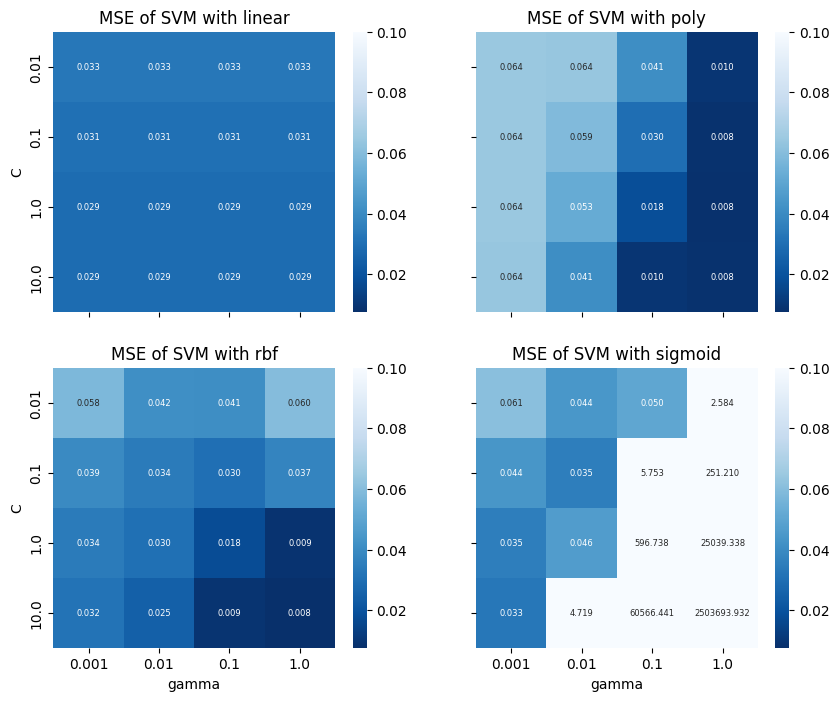

In [24]:
heatmap_df = recording_save_df.copy().reset_index().drop(columns=['index', 'mean_test', 'ranking']).set_index(['kernel'])
min_range = heatmap_df['mean_train'].min()

# Set up the matplotlib figure
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8), sharex=True, sharey=True)

# Plot heatmap each kernel
for index, kernel in enumerate(heatmap_df.index.unique()):
    ax = axes[index // 2, index % 2]
    data_plot = heatmap_df.loc[kernel].copy()\
        .reset_index().drop(columns=['kernel'])\
        .set_index(['C', 'gamma'])
    data_plot = data_plot['mean_train'].unstack('gamma').rename_axis(None, axis=1)
    data_plot.index.name = None
    sns.heatmap(data_plot, annot=True, ax=ax,
                vmin=min_range, vmax=0.1, fmt='.3f',
                cmap='Blues_r', annot_kws={"size": 6})
    ax.set_title('MSE of SVM with ' + kernel)
    if index % 2 == 0:
        ax.set_ylabel('C')
        
    if index // 2 == 1:
        ax.set_xlabel('gamma')

plt.show()

It appears that the `poly` and `sigmoid` kernels have lighter colors compared to the `linear` and `rbf` kernels. Specifically, when using the `sigmoid` kernel, the MSE tends to increase as the hyperparameter gets larger. This indicates that when the penalty coefficient `C` is higher, the SVM with sigmoid tends to suffer from **_underfitting_**.

Let's check if **_overfitting_** occurs with small MSE kernel hyperparameters.

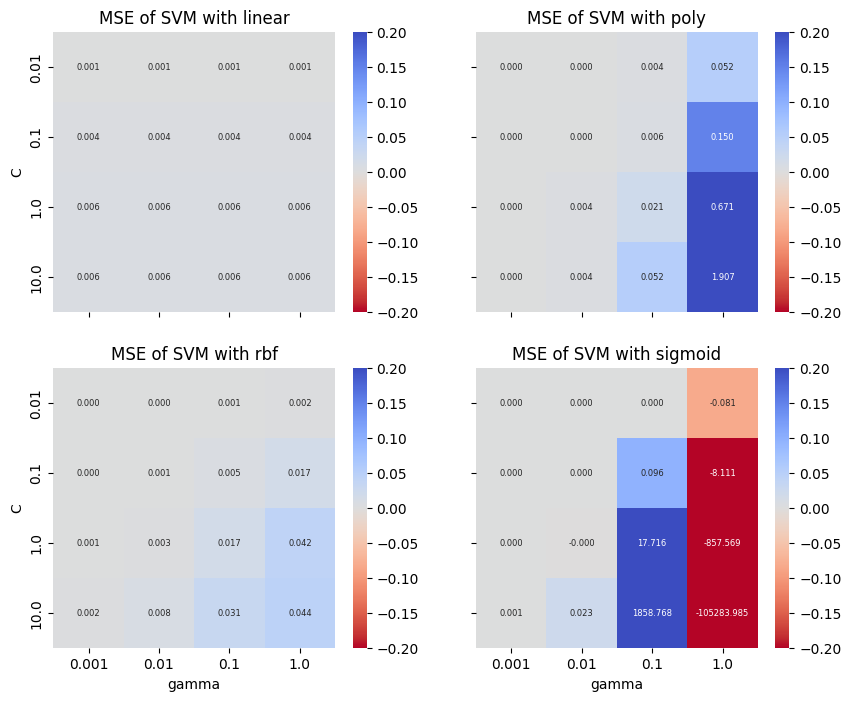

In [25]:
bar_df = pd.DataFrame({'kernel': recording_save_df['kernel'],
                       'C': recording_save_df['C'],
                       'gamma': recording_save_df['gamma'],
                       'influence_level': recording_save_df['mean_test'] - recording_save_df['mean_train']},
                       index=recording_save_df.index)
bar_df = bar_df.reset_index().drop(columns=['index']).set_index(['kernel'])

# Set up the matplotlib figure
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8), sharex=True, sharey=True)

# Plot heatmap each kernel
for index, kernel in enumerate(bar_df.index.unique()):
    ax = axes[index // 2, index % 2]
    data_plot = bar_df.loc[kernel].copy()\
        .reset_index().drop(columns=['kernel'])\
        .set_index(['C', 'gamma'])
    data_plot = data_plot['influence_level'].unstack('gamma').rename_axis(None, axis=1)
    data_plot.index.name = None
    sns.heatmap(data_plot, annot=True, ax=ax,
                vmin=-0.2, vmax=0.2, fmt='.3f',
                cmap='coolwarm_r', annot_kws={"size": 6})
    ax.set_title('MSE of SVM with ' + kernel)
    if index % 2 == 0:
        ax.set_ylabel('C')
        
    if index // 2 == 1:
        ax.set_xlabel('gamma')

plt.show()

In [ ]:

# # Fit and transform the training data using the preprocessor
# pd.DataFrame(preprocessor.fit_transform(X_train, y_train))

# # # Transform the validation and test data using the preprocessor
# # X_val_preprocessed = preprocessor.transform(X_val)
# # X_test_preprocessed = preprocessor.transform(X_test)

array([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
       0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 1.0, 1.0, 1.0, 1.0,
       1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 10.0,
       10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0,
       10.0, 10.0, 10.0, 10.0], dtype=object)

In [ ]:
# Import data
data = np.loadtxt("data.csv", dtype=float, delimiter=",")

# Create figure
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")

# Plot data
ax.scatter(data[:, 0], data[:, 1], data[:, 2], c=data[:, 3])

# Set labels
ax.set_xlabel("C")
ax.set_ylabel("Gamma")
ax.set_zlabel("Kernel")
ax.set_title("Mean test score")

# Show figure
plt.show()


In [ ]:
# print("Grid scores on development set:")

# means = gs_spe.cv_results_['mean_test_score']
# stds = gs_spe.cv_results_['std_test_score']
# i = 0
# for mean, std, params in zip(means, stds, gs_spe.cv_results_['params']):
#     print("[%d]: %0.4f (+/-%0.03f) for %r"
#           % (i, -mean, std * 2, params))
#     i += 1

Grid scores on development set:
[0]: 0.0579 (+/-0.008) for {'regressor__C': 0.01, 'regressor__gamma': 0.001, 'regressor__kernel': 'rbf'}
[1]: 0.0610 (+/-0.008) for {'regressor__C': 0.01, 'regressor__gamma': 0.001, 'regressor__kernel': 'sigmoid'}
[2]: 0.0417 (+/-0.006) for {'regressor__C': 0.01, 'regressor__gamma': 0.01, 'regressor__kernel': 'rbf'}
[3]: 0.0442 (+/-0.005) for {'regressor__C': 0.01, 'regressor__gamma': 0.01, 'regressor__kernel': 'sigmoid'}
[4]: 0.0420 (+/-0.008) for {'regressor__C': 0.01, 'regressor__gamma': 0.1, 'regressor__kernel': 'rbf'}
[5]: 0.0506 (+/-0.007) for {'regressor__C': 0.01, 'regressor__gamma': 0.1, 'regressor__kernel': 'sigmoid'}
[6]: 0.0623 (+/-0.009) for {'regressor__C': 0.01, 'regressor__gamma': 1.0, 'regressor__kernel': 'rbf'}
[7]: 2.5029 (+/-0.381) for {'regressor__C': 0.01, 'regressor__gamma': 1.0, 'regressor__kernel': 'sigmoid'}
[8]: 0.0396 (+/-0.005) for {'regressor__C': 0.1, 'regressor__gamma': 0.001, 'regressor__kernel': 'rbf'}
[9]: 0.0441 (+/-0.